# Deepfake Detection - Model Training EfficientNet

## Setup and Imports

In [1]:
from platform import python_version

python_version()

'3.9.12'

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import tensorflow as tf
from tensorflow import keras

tf.__version__, keras.__version__

('2.9.1', '2.9.0')

In [4]:
import os

# Check GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enables use of the GPU on a Mac using plaidml (ignore otherwise)

Num GPUs Available:  0


In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import random
import sys

from tqdm import tqdm

from typing import List

## Load dataset

In [6]:
DATASET_PATH = "../dataset-sample-faces.csv"

In [7]:
data = pd.read_csv(DATASET_PATH)

data.head()

,image_filename,image_fullpath,face_confidence,label,video_filename,video_fullpath,video_dataset
0,id0_0000_1.png,../extracted_faces/id0_0000/id0_0000_1.png,0.997610,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
1,id0_0000_15.png,../extracted_faces/id0_0000/id0_0000_15.png,0.996413,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
2,id0_0000_29.png,../extracted_faces/id0_0000/id0_0000_29.png,0.999750,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
3,id0_0000_43.png,../extracted_faces/id0_0000/id0_0000_43.png,0.995511,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
4,id0_0000_57.png,../extracted_faces/id0_0000/id0_0000_57.png,0.997212,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2


In [8]:
list(data.columns)

['image_filename',
 'image_fullpath',
 'face_confidence',
 'label',
 'video_filename',
 'video_fullpath',
 'video_dataset']

In [9]:
data['label'].value_counts()

REAL    48200
FAKE    46832
Name: label, dtype: int64

In [10]:
data = data.sample(n=40000, random_state=42)

In [11]:
data['label'].value_counts()

REAL    20184
FAKE    19816
Name: label, dtype: int64

Although, there is a slight imbalance in the dataset as seen above, we sampled the number of "FAKE" videos equal to the number of "REAL" videos in the notebook [Deepfake Detection - Dataset Preparation.ipynb](./Deepfake%20Detection%20-%20Dataset%20Preparation.ipynb)

## Data Splitting

To ensure that images from a video in the train dataset is not in the validation/test dataset, a custom split function was made.

In [12]:
def split_dataframe(data, test_size, column, shuffle=False, random_state=1):
  """Splits the dataframe based on unique values in a given 
  column."""
  # Gets a list of unique videos 
  videos = list(data[column].unique())
  n = len(videos)
  k = int(0.2 * n)

  if shuffle:
    data = data.sample(frac=1)

  # Sets the random state
  random.seed(random_state)
  split_videos = random.sample(videos, k)

  df1 = data[data[column].isin(split_videos)]
  df2 = data[~data[column].isin(split_videos)]
  
  assert(len(df1[df1.isin(df2)].dropna()) == 0)
  
  df1.sort_index(inplace=True)
  df2.sort_index(inplace=True)
  
  return df2, df1

In [13]:
TRAIN_SPLIT = 0.2
VAL_SPLIT = 0.25

train_df, test_df = split_dataframe(data=data, 
                                    test_size=TRAIN_SPLIT,
                                    column="video_filename",
                                    shuffle=True,
                                    random_state=42)

train_df, val_df = split_dataframe(data=data, 
                                  test_size=VAL_SPLIT,
                                  column="video_filename",
                                  random_state=42)

C:\Users\Michelle\AppData\Local\Temp\ipykernel_21648\1251354954.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_index(inplace=True)
C:\Users\Michelle\AppData\Local\Temp\ipykernel_21648\1251354954.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_index(inplace=True)


In [14]:
train_df['label'].value_counts()

FAKE    16125
REAL    15885
Name: label, dtype: int64

In [15]:
test_df['label'].value_counts()

REAL    4299
FAKE    3691
Name: label, dtype: int64

In [16]:
val_df['label'].value_counts()

REAL    4299
FAKE    3691
Name: label, dtype: int64

## Data Augmentation 

**Gaussian Noise:**

**Random Erasing:** https://arxiv.org/abs/1708.04896
    - Source code: https://github.com/zhunzhong07/Random-Erasing

In [17]:
import math
import random
from keras.preprocessing.image import ImageDataGenerator

def gaussian_noise(image, probability):
  if random.uniform(0,1) > probability:
    return image
  row,col,ch= image.shape
  mean = 0
  var = 0.01 # slightly reduced
  sigma = var ** 0.5
  gauss = np.random.normal(mean,sigma,(row,col))
  noisy = image
  for i in range(ch):
    noisy[:,:,i] = image[:,:,i] + gauss
  return noisy


def random_erasing(img, probability):
  """
  Performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.

  probability: The probability that the operation will be performed.
  sl: min erasing area
  sh: max erasing area
  r1: min aspect ratio
  mean: erasing value

  Note: Code modified for img.shape parameters instead of img.size()
  """
  # Source: https://github.com/zhunzhong07/Random-Erasing
  if random.uniform(0,1) > probability:
    return img

  # Default params
  mean = [0.4914, 0.4822, 0.4465]
  sl = 0.02
  sh = 0.4
  r1 = 0.3

  for attempt in range(100):
    area = img.shape[0] * img.shape[1]

    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)

    h = int(round(math.sqrt(target_area * aspect_ratio)))
    w = int(round(math.sqrt(target_area / aspect_ratio)))

    if w < img.shape[0] and h < img.shape[1]:
        x1 = random.randint(0, img.shape[1] - h)
        y1 = random.randint(0, img.shape[0] - w)
        if img.shape[2] == 3:
            img[x1:x1+h, y1:y1+w, 0] = mean[0]
            img[x1:x1+h, y1:y1+w, 1] = mean[1]
            img[x1:x1+h, y1:y1+w, 2] = mean[2]
        else:
            img[0, x1:x1+h, y1:y1+w] = mean[0]

        return img
  return img

class CustomDataGenerator(ImageDataGenerator):
  '''
  Custom image data generator.
  Allows image compression and random erasing.
  '''
  def __init__(self, 
               gaussian_noise : float = 0., 
               random_erasing : float = 0.,
               **kwargs):
    super().__init__(preprocessing_function=self.custom_augmentations,
                    **kwargs)
    self.gaussian_noise = gaussian_noise
    self.random_erasing = random_erasing
  
  def custom_augmentations(self, image):
    image = gaussian_noise(image, self.gaussian_noise)
    image = random_erasing(image, self.random_erasing)
    return image

In [18]:
train_datagen = CustomDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  rotation_range=0.1,
                                  horizontal_flip=True,
                                  # Custom augmentation probabilities
                                  gaussian_noise=0.1,
                                  random_erasing=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
IMAGE_DIM = 256
BATCH_SIZE = 4

train_generator = train_datagen.flow_from_dataframe(
  dataframe = train_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = BATCH_SIZE,
  seed = 42,
  class_mode = "binary",
  target_size=(IMAGE_DIM, IMAGE_DIM)
)

valid_generator = train_datagen.flow_from_dataframe(
  dataframe = val_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = BATCH_SIZE,
  seed = 42,
  class_mode = "binary",
  target_size=(IMAGE_DIM, IMAGE_DIM)
)

test_generator = test_datagen.flow_from_dataframe(
  dataframe = test_df, 
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size=BATCH_SIZE,
  seed = 42,
  shuffle=False,
  class_mode="binary",
  target_size=(IMAGE_DIM, IMAGE_DIM)
)

Found 32010 validated image filenames belonging to 2 classes.
Found 7990 validated image filenames belonging to 2 classes.
Found 7990 validated image filenames belonging to 2 classes.


## EfficientNet Model

In [20]:
class EfficientNet:
    def __init__(self, input_size, n_freeze=143, dropout=0.5):
        self.input_size = input_size
        self.n_freeze = n_freeze
        self.dropout = dropout
        self.model = self._initialise_model()
        self.history = None
    
    def _initialise_model(self):
        input_t = keras.Input(shape=self.input_size)
        base_model = keras.applications.EfficientNetB7(
            include_top=False,
            weights="imagenet",
            input_tensor=input_t,
        )
        model = keras.models.Sequential()
        model.add(base_model)
        model.add(keras.layers.GlobalAveragePooling2D()) # v1
#         model.add(keras.layers.Flatten()) # v0
        model.add(keras.layers.Dropout(self.dropout))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        return model
    
    def train_model(self, train_generator, valid_generator,
                   epochs, learning_rate=0.0001,
                   save_model:str=None,
                   verbose=1):
        train_steps = len(train_generator)
        val_steps = len(valid_generator)
        check_point = keras.callbacks.ModelCheckpoint(
            filepath="../weights/efficientnetb7-v7-{epoch:02d}.hdf5",
            monitor="val_loss",
            save_best_only=True
        )
        self.model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
            metrics=['accuracy']
        )
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=val_steps,
            verbose=verbose,
            callbacks=[check_point]
        )
        
        if save_model is not None:
          self.save_model(save_model)
        return self.history.history

    def save_model(self,filepath):
        self.model.save(filepath)

    def get_history(self):
        return self.history.history

In [21]:
# v0 training - flatten layer
model0 = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), n_freeze=-8, dropout=0.25)

In [ ]:
history0 = model0.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=20,
                            learning_rate=0.0001,
                            save_model="../weights/efficientnetb7-v2.h5")

pickle_path = "pickle/efficientnetb7-v2.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history0, f)

Epoch 1/20


## Model load

In [24]:
pickle_path = "pickle/efficientnetb7-v2.pickle"

with open(pickle_path, "rb") as f:
  history = pickle.load(f)

In [26]:
def plot_loss_and_accuracy(history, figsize=(15,6)):
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  ax[0].plot(history['loss'], label='train_loss')
  ax[0].plot(history['val_loss'], label='valid_loss')
  ax[0].set_title("Loss")
  ax[0].set_xlabel("epoch")
  ax[0].set_ylabel("loss")
  ax[0].legend()
  ax[1].plot(history['accuracy'], label='train_acc')
  ax[1].plot(history['val_accuracy'], label='valid_acc')
  ax[1].set_title("Accuracy")
  ax[1].set_xlabel("epoch")
  ax[1].set_ylabel("accuracy")
  ax[1].legend()

  plt.show()

    
# plot_loss_and_accuracy(history)

## Model Evaluations

In [21]:
def model_predict(model, test_generator):
    # Runs prediction on test dataset
    test_generator.reset()
    pred = model.predict(test_generator,steps=len(test_generator), verbose=1)
    
    # Creates a dictionary to search for the video_filename: array of frame predictions
    real_labels = test_generator.labels
    filenames = test_generator.filenames
    prediction = {}
    real_prediction = {}
    for f, p, r in zip(filenames, pred, real_labels):
        pred_video_filename = test_df[test_df['image_fullpath'] == f]['video_filename'].iloc[0]
        if pred_video_filename in prediction.keys():
            prediction[pred_video_filename].append(p[0])
            real_prediction[pred_video_filename].append(r)
        else:
            prediction[pred_video_filename] = [ p[0] ]
            real_prediction[pred_video_filename] = [r]

    # Averages the prediction scores for each video
    prediction = { k: sum(v)/len(v) for k,v in prediction.items() }
    real_prediction = { k: int(sum(v)/len(v)) for k,v in real_prediction.items() }
    
    pred_vid_filenames = list(prediction.keys())
    pred_vid = list(prediction.values())
    real_indices = list(real_prediction.values())
    
    return pred_vid_filenames, pred_vid, real_indices

def predict_indices(pred, thresh=0.5):
    return [1 if p > thresh else 0 for p in pred ]

from sklearn.metrics import classification_report

def show_classification_report(test_y, pred_y):
    report = classification_report(test_y, pred_y, digits=4, zero_division=0)
    print(report)
    
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(test_y, pred_y, axis_labels):
    confusion = confusion_matrix(test_y, pred_y)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    fig, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_normalized, 
                     xticklabels=axis_labels, 
                     yticklabels=axis_labels,
                     cmap='Blues', 
                     annot=True,
                     fmt = '.2f',
                     square = True
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [24]:
# v0 - Flatten
effnet = keras.models.load_model("../weights/efficientnetb7-v7-02.hdf5")

test_generator.reset()
image_loss, image_acc = effnet.evaluate(test_generator)
test_x, pred_y, test_y = model_predict(effnet, test_generator)

image_loss, image_acc 

1998/1998 [==============================] - 1418s 708ms/step


(0.21942657232284546, 0.9261577129364014)

In [27]:
print("Image loss     :", image_loss)
print("Image accuracy :", image_acc)

Image loss     : 0.21942657232284546
Image accuracy : 0.9261577129364014


              precision    recall  f1-score   support

           0     0.9537    0.9606    0.9571       279
           1     0.9655    0.9595    0.9625       321

    accuracy                         0.9600       600
   macro avg     0.9596    0.9600    0.9598       600
weighted avg     0.9600    0.9600    0.9600       600



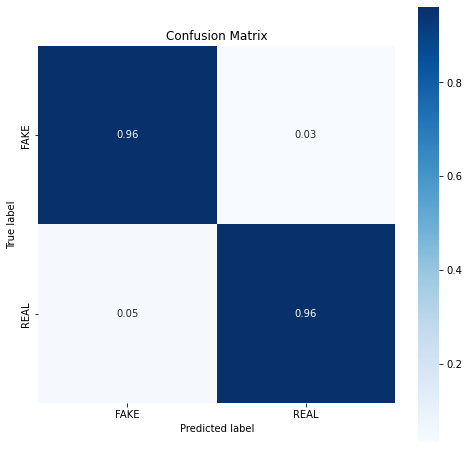

In [25]:
# Converts predictions to binary
pred_y_indices = predict_indices(pred_y, thresh=0.5)

show_classification_report(test_y, pred_y_indices)

axis_labels = list(test_generator.class_indices)
show_confusion_matrix(test_y, pred_y_indices, axis_labels)